## imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression

import warnings

warnings.filterwarnings("ignore")


In [3]:
data = pd.read_csv("dataset.csv")
train, validation = train_test_split(data, test_size=0.33, random_state=42)


## visaualization functions

In [4]:
def describe_nums(df: pd.DataFrame, sort_by="unique"):
    return (
        df.nunique()
        .to_frame()
        .rename(columns={0: "unique"})
        .join(df.isna().sum().to_frame().rename(columns={0: "n/a count"}))
        .join(df.describe().T, how="left")
        .sort_values([sort_by], ascending=False)
        .style.bar(["mean"])
        .background_gradient(subset=["50%"], cmap="viridis")
        .background_gradient(subset=["std"], cmap="Reds")
        .bar("unique", color="lightblue")
    )


def show_IQR(series, bins_n=None):

    perc_25 = series.quantile(0.25, interpolation="midpoint")
    perc_75 = series.quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25

    print(
        f"Unique values count: {series.nunique()}",
        f"\nQ1: {perc_25}\nQ3: {perc_75}\nIQR: {IQR}",
        f"\nOutliers borders: [{perc_25 - 1.5*IQR}, {perc_75 + 1.5*IQR}]",
    )

    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    sns.distplot(series.values, bins=bins_n, color="#50248f", ax=axes[0]).set(
        xlabel=series.name,
        ylabel="Quantity (frequency)",
        title=series.name + " distribution\n",
    )

    sns.boxplot(series.values, color="#38d1ff", ax=axes[1]).set(
        xlabel=series.name, title=series.name + " distribution\n"
    )

    plt.show()


def show_boxplots(df, cat, numeric):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        x=cat,
        y=numeric,
        data=df,
        ax=ax,
    )
    ax.set_title("Boxplot for: " + cat + " vs " + numeric)
    plt.show()


## first view

In [5]:
data.shape


(73799, 14)

## общий вид

In [6]:
data.dtypes


client_id            int64
education           object
sex                 object
age                  int64
car                 object
car_type            object
decline_app_cnt      int64
good_work            int64
bki_request_cnt      int64
home_address         int64
work_address         int64
income               int64
foreign_passport    object
default              int64
dtype: object

In [7]:
data.sample(10)


,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
70357,75940,GRD,M,31,Y,Y,0,0,3,2,3,50000,N,1
41665,92897,PGR,M,28,N,N,0,0,0,2,3,55000,N,0
46826,1268,SCH,M,40,N,N,0,0,0,3,3,300000,Y,0
13782,96093,SCH,F,58,N,N,0,0,0,2,3,20000,N,0
41241,20709,GRD,M,32,N,N,0,1,6,2,3,100000,N,0
66362,27778,GRD,M,49,Y,Y,0,0,3,1,2,80000,N,1
70643,61628,SCH,F,61,N,N,0,0,3,2,3,50000,N,0
61261,8631,SCH,M,58,N,N,0,0,3,2,3,35000,N,0
67318,100650,SCH,M,33,Y,Y,0,0,3,2,3,150000,Y,0
4174,34335,SCH,F,34,N,N,0,0,1,2,3,14000,N,1


### цифровые

по факту следующие цифровые переменные также стоит считать категориальными:

- home_address
- work_address
- good_work
- default

In [8]:
describe_nums(
    data.drop(["client_id", "income", "age"], axis="columns").select_dtypes("int64")
)


,unique,n/a count,count,mean,std,min,25%,50%,75%,max
bki_request_cnt,38,0,73799.000000,2.000339,2.252073,0.000000,0.000000,1.000000,3.000000,53.000000
decline_app_cnt,21,0,73799.000000,0.275749,0.804272,0.000000,0.000000,0.000000,0.000000,33.000000
home_address,3,0,73799.000000,1.575509,0.527631,1.000000,1.000000,2.000000,2.000000,3.000000
work_address,3,0,73799.000000,2.496280,0.689818,1.000000,2.000000,3.000000,3.000000,3.000000
good_work,2,0,73799.000000,0.164894,0.371087,0.000000,0.000000,0.000000,0.000000,1.000000
default,2,0,73799.000000,0.126994,0.332968,0.000000,0.000000,0.000000,0.000000,1.000000


### категориальные

In [9]:
data.select_dtypes("object").describe().T.sort_values("freq", ascending=False)


,count,unique,top,freq
foreign_passport,73799,2,N,62733
car_type,73799,2,N,59791
car,73799,2,N,49832
sex,73799,2,F,41562
education,73492,5,SCH,38860


In [10]:
data.work_address.unique().tolist(), data.home_address.unique().tolist()


([2, 3, 1], [1, 2, 3])

### делим на списки

In [11]:
nums = ["income", "age", "bki_request_cnt", "decline_app_cnt"]
cats = [
    "home_address",
    "work_address",
    "good_work",
    "default",
    "foreign_passport",
    "car_type",
    "car",
    "sex",
    "education",
]


### деление в задании

In [12]:
# бинарные переменные
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные переменные
cat_cols = ["education", "work_address", "home_address"]

# числовые переменные

num_cols = ["age", "decline_app_cnt", "bki_request_cnt", "income"]


### корреляция числовых переменных

они почти не скоррелированы, что неплохо для нас, не надо избавляться от мультиколлинеарности

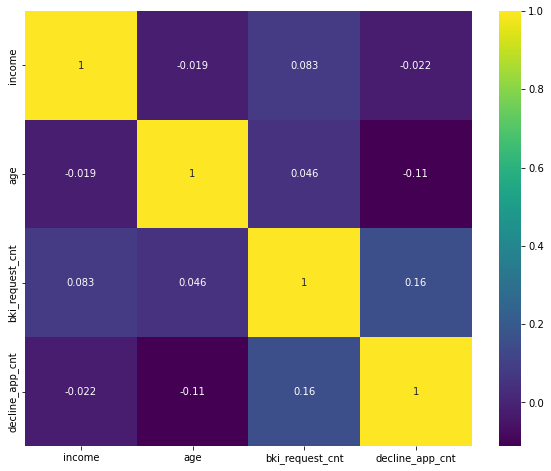

In [13]:
plt.subplots(figsize=(10, 8))
sns.heatmap(data[nums].corr(), cmap="viridis", annot=True)
plt.show()


## preprocessing

### значимость числовых призников

<AxesSubplot:>

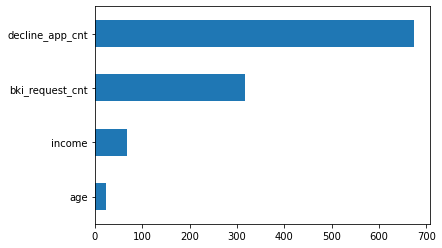

In [14]:
imp_num = pd.Series(f_classif(train[num_cols], train["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind="barh")


### label encoding

Почему мы применили метод только к бинарным переменным? Единственным минусом использования кодирования при помощи LabelEncoder() является то, что при использовании этого подхода мы должны быть уверены, что признак не может принимать неизвестных ранее значений. 

In [15]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    validation[column] = label_encoder.fit_transform(validation[column])

# убедимся в преобразовании
train.head()


,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
8931,104346,GRD,0,27,0,0,0,0,3,2,3,30000,0,0
63915,56248,GRD,0,47,0,0,0,0,4,1,2,20000,0,0
45568,59433,SCH,0,47,0,0,0,0,0,2,3,45000,0,0
3391,21096,SCH,0,32,0,0,0,0,3,2,3,21000,0,1
40660,18878,SCH,0,31,0,0,0,1,6,2,3,30000,1,0


In [16]:
train["education"].unique().tolist()


['GRD', 'SCH', 'UGR', 'PGR', 'ACD', nan]

In [17]:
train["education"] = train["education"].map(
    {"GRD": 1, "SCH": 2, "UGR": 3, "PGR": 4, "ACD": 5, np.nan: 6}
)

validation["education"] = validation["education"].map(
    {"GRD": 1, "SCH": 2, "UGR": 3, "PGR": 4, "ACD": 5, np.nan: 6}
)


### значимость категориальных признаков

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

<AxesSubplot:>

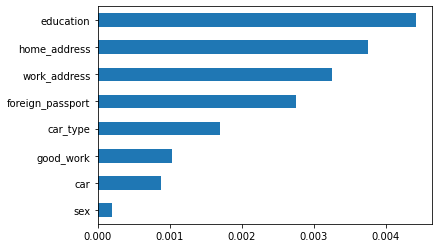

In [18]:
imp_cat = pd.Series(
    mutual_info_classif(
        train[bin_cols + cat_cols], train["default"], discrete_features=True
    ),
    index=bin_cols + cat_cols,
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind="barh")


### one hot encoder

In [19]:
X_cat_train = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
X_cat_validation = OneHotEncoder(sparse=False).fit_transform(validation[cat_cols].values)


In [20]:
X_cat_train.shape, X_cat_validation


((49445, 12),
 array([[0., 0., 1., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 1., 0., 0.]]))

### стандартизируем

In [21]:
X_num_train = StandardScaler().fit_transform(train[num_cols].values)
X_num_validation = StandardScaler().fit_transform(validation[num_cols].values)

X_train = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
y_train = train["default"].values

X_validation = np.hstack([X_num_validation, validation[bin_cols].values, X_cat_validation])
y_validation = validation["default"].values

## углубляемся в переменные

фича education

In [22]:
data.education.fillna("NA", inplace=True)


In [23]:
data.education.value_counts().to_frame()


,education
SCH,38860
GRD,23365
UGR,9816
PGR,1257
NA,307
ACD,194


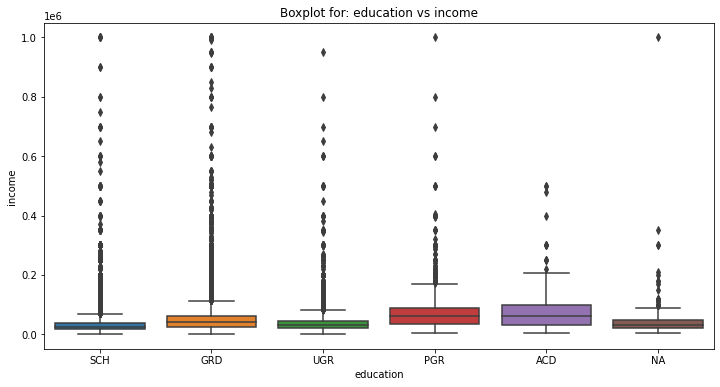

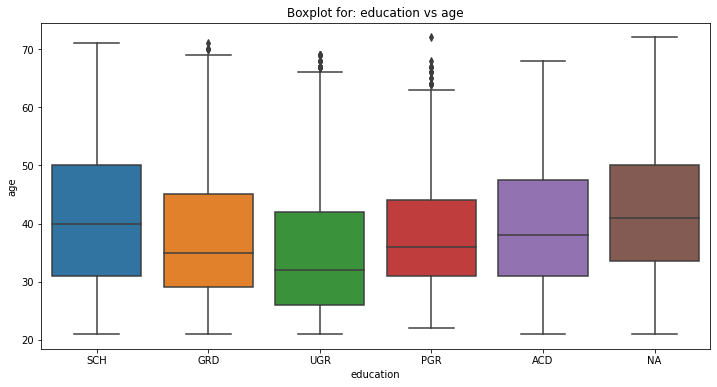

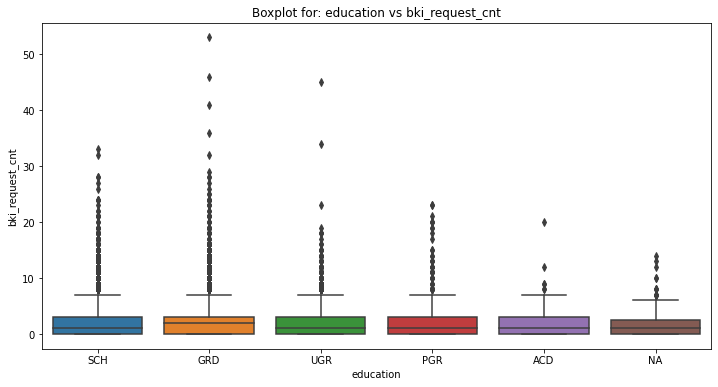

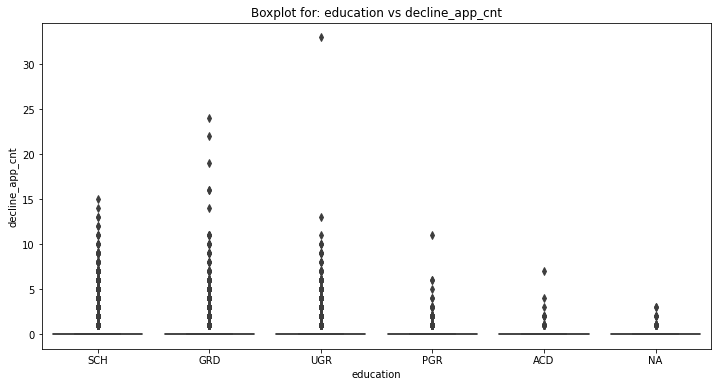

In [24]:
for n in nums:
    show_boxplots(data, "education", n)


логорифмируем

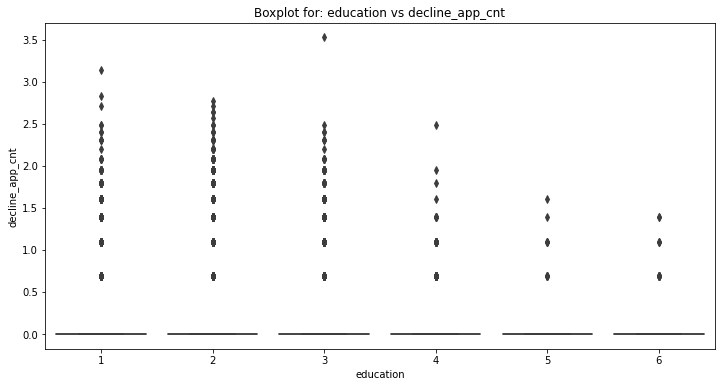

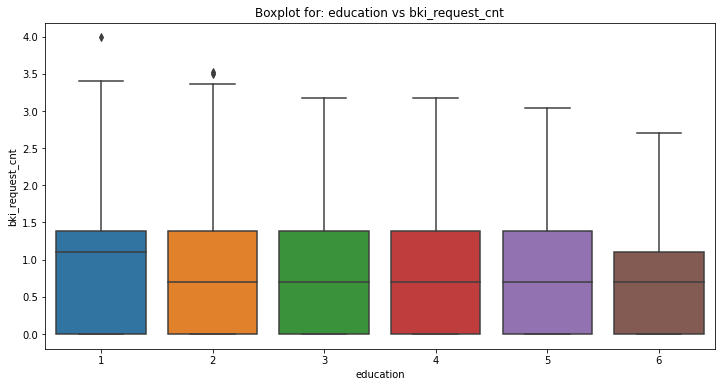

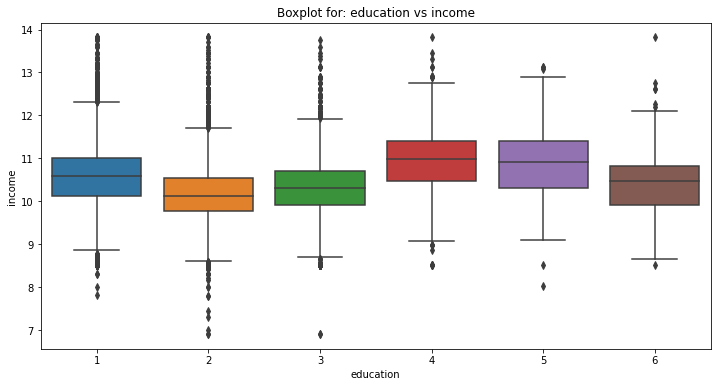

In [25]:
# большие хвосты, надо отлогорифмировать числовые переменные, кроме возможно возраста
# обратная операция делается с помощью np.exp на вектор целиком

for n in ["decline_app_cnt", "bki_request_cnt", "income"]:
    train[n] = train[n].apply(lambda w: np.log(w + 1))
    validation[n] = validation[n].apply(lambda w: np.log(w + 1))
    show_boxplots(train, "education", n)


фича default

In [26]:
data.default.value_counts().to_frame()


,default
0,64427
1,9372


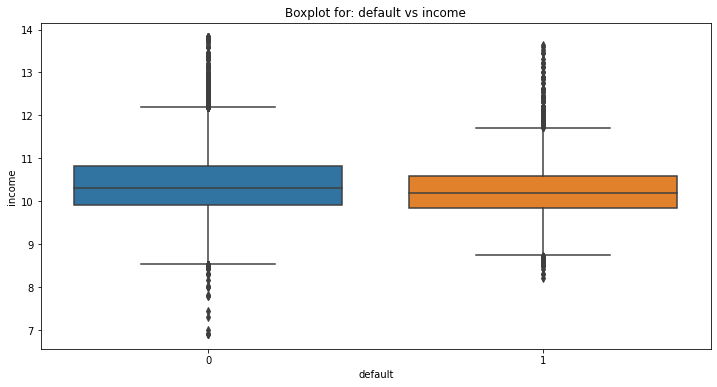

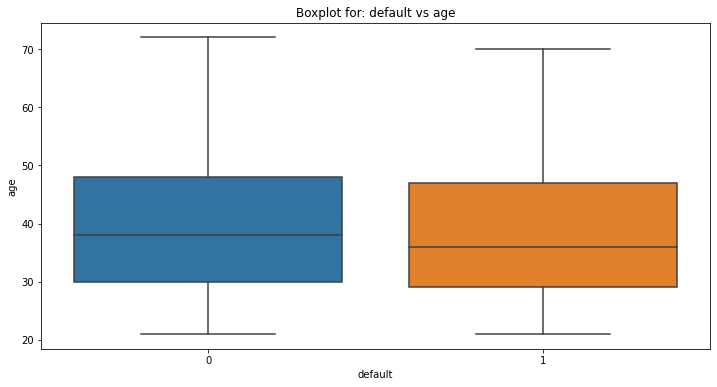

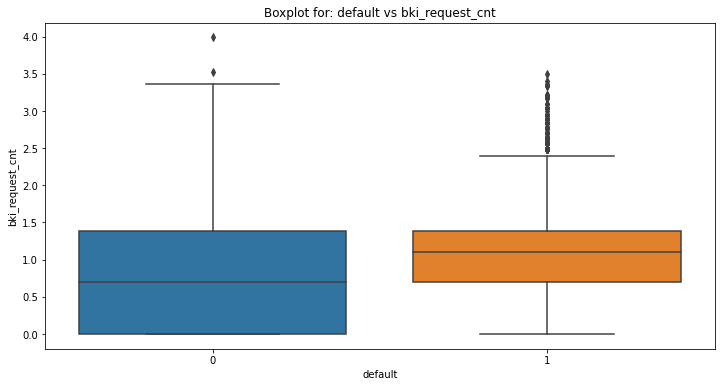

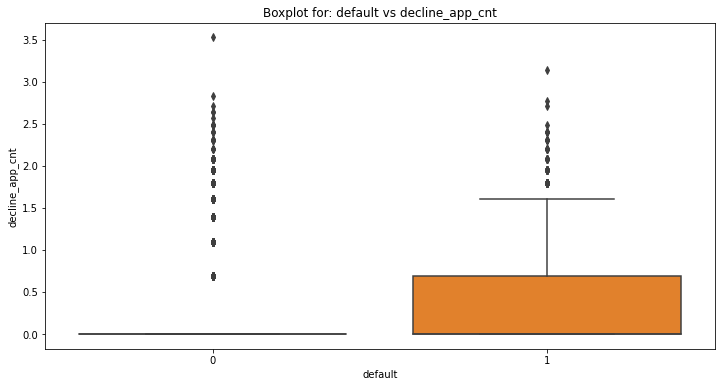

In [27]:
for n in nums:
    show_boxplots(train, "default", n)


фича age

Unique values count: 52 
Q1: 30.0
Q3: 48.0
IQR: 18.0 
Outliers borders: [3.0, 75.0]


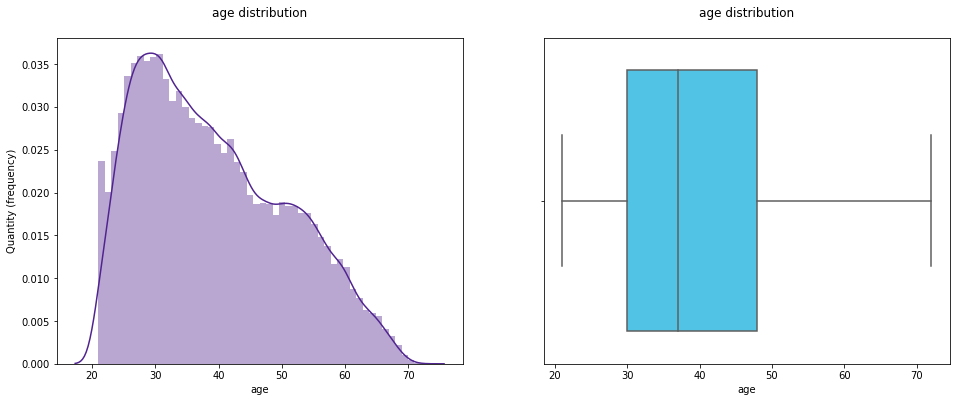

In [28]:
show_IQR(data.age)


фича income

Unique values count: 966 
Q1: 20000.0
Q3: 48000.0
IQR: 28000.0 
Outliers borders: [-22000.0, 90000.0]


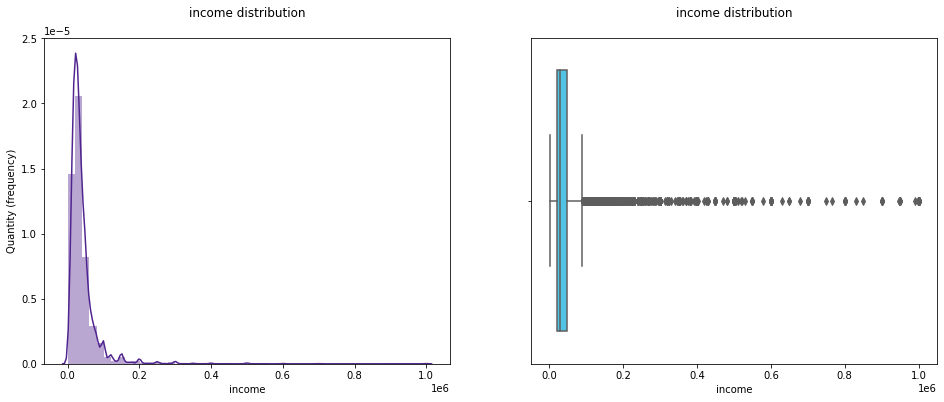

In [29]:
show_IQR(data.income)


## оценка качества модели

model

In [30]:
model = LogisticRegression().fit(X_train, y_train)

In [31]:
y_pred_on_train = model.predict(X_train)
y_pred_on_validation = model.predict(X_validation)

[confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

In [32]:
confusion_matrix(y_train, y_pred_on_train)

array([[43054,    79],
       [ 6260,    52]], dtype=int64)

In [33]:
confusion_matrix(y_validation, y_pred_on_validation)

array([[21255,    39],
       [ 3031,    29]], dtype=int64)

roc_auc

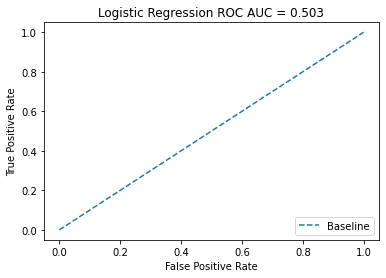

In [34]:
roc_auc = roc_auc_score(y_train, y_pred_on_train)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()